In [1]:
import os
import time
import gymnasium as gym
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns
from tqdm import tqdm, trange

C:\Users\duasp\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Some Basic Directories for housekeeping
# set location of input files:
inpDir = os.path.join( '..', 'input')

outDir = os.path.join('..', 'output')

# define and set random state 
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible results
SMALL_ENOUGH = 1e-3
GAMMA = 1.0    # 0.99
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')
EPISODES = 100000

CMAP = plt.cm.rainbow
plt.set_cmap(CMAP);
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

# Define constants for data manipulation
TEST_SIZE = 0.2
NOISE = 0.2
N_SAMPLE = 1024

<Figure size 640x480 with 0 Axes>

In [3]:
# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',    
          'figure.figsize': (12, 8),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large',
          'savefig.dpi': 75,
          'image.cmap': 'summer',
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 1,
          'legend.numpoints' : 1
         }


plt.rcParams.update(params)

'''plt.rc('axes', prop_cycle=(
    cycler('color', mglearn.plot_helpers.cm_cycle.colors) +
    cycler('linestyle', ['-', '-', "--", (0, (3, 3)), (0, (1.5, 1.5))])))
'''
np.set_printoptions(precision=3, suppress=True)

pd.set_option("display.max_columns", 8)
pd.set_option('display.precision', 2)

__all__ = ['np', 'display', 'plt', 'pd', 'sklearn', 'seaborn']

### frozen Lake -v1

In [4]:
action_mapping = {
    0: '\u2190',    #Left
    1:'\u2193',     #Down
    2:'\u2192',    #right
    3:'\u2191',    #Up
}
print(action_mapping)

{0: '←', 1: '↓', 2: '→', 3: '↑'}


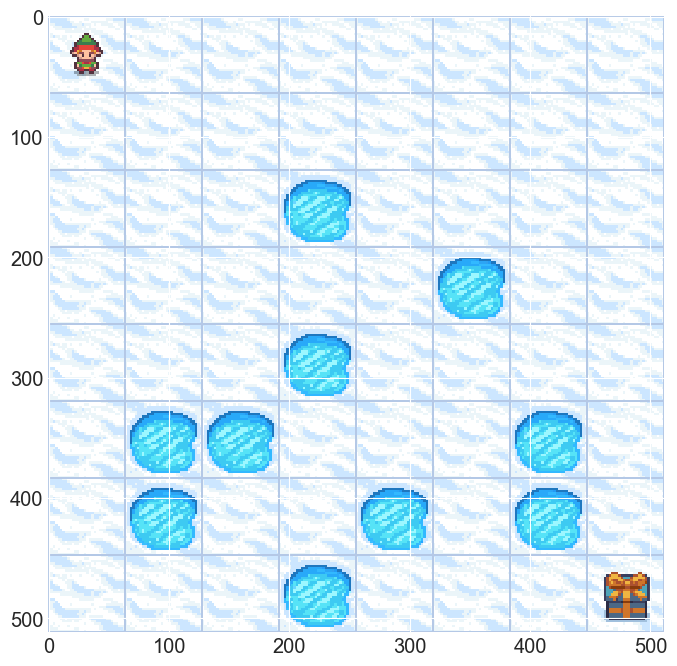

In [5]:
env  =gym.make('FrozenLake-v1',
               map_name = '8x8',
               render_mode='rgb_array',
               is_slippery=True)

env.reset(seed=RANDOM_STATE)

img=plt.imshow(env.render())

0 0.0 False False {'prob': 0.3333333333333333}


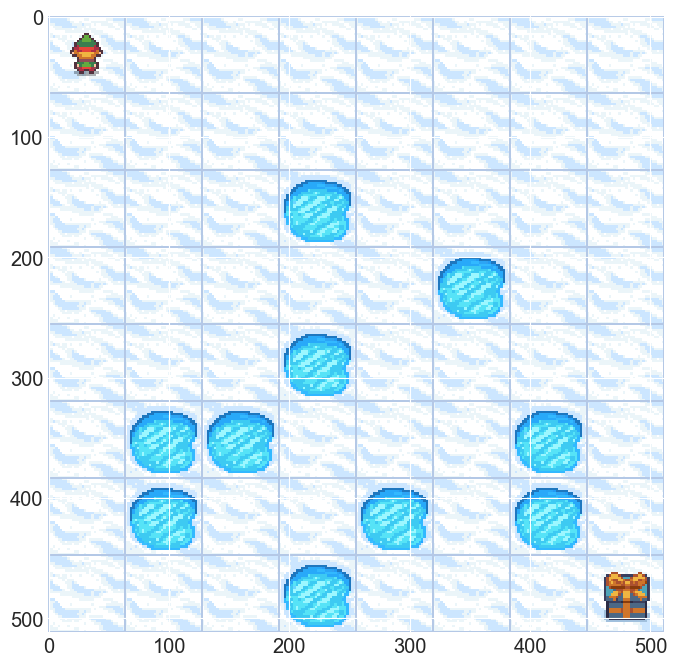

In [6]:
env.reset()
action = 3
#env.step(action)
observation, reward, terminated, truncated, prob = env.step(action)

img  = plt.imshow(env.render())

print(observation, reward, terminated, truncated, prob)

In [7]:
env.reset()

(0, {'prob': 1})

In [8]:
env.action_space

Discrete(4)

In [9]:
env.observation_space

Discrete(64)

In [10]:
env.step(1)

(8, 0.0, False, False, {'prob': 0.3333333333333333})

In [11]:
env.action_space.sample()

3

### Generate Episodes

In [12]:
def fn_generate_episodes(env):
    '''
    Args:
        env: Gymnasium Envirnment
        
    Return:
        list of states actions and rewards
    '''
    states, actions, rewards = [], [], []
    
    observation = env.reset()[0]
    
    while True:
        states.append(observation)
        action = env.action_space.sample()
        actions.append(action)
        
        #Take that action
        observation, reward, terminated, truncated, info  =env.step(action)
        rewards.append(reward)
        
        done = terminated or truncated
        
        if done:
            break  
    return states, actions, rewards 

In [13]:
states, actions, rewards = fn_generate_episodes(env)

print(f'states:{states}\nActions:{actions}\nRewards:{rewards}')

states:[0, 1, 1, 1, 1, 2, 3, 11, 10, 11, 10, 9, 8, 9, 17, 25, 17, 16, 24, 16, 16, 16, 8, 16, 17, 18, 10, 9, 8, 0, 8, 0, 8, 9, 17, 18, 26, 27]
Actions:[1, 0, 2, 2, 1, 2, 0, 1, 1, 0, 1, 1, 2, 2, 1, 3, 3, 1, 0, 3, 3, 0, 1, 2, 1, 3, 1, 3, 0, 0, 0, 2, 3, 0, 3, 2, 3, 0]
Rewards:[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


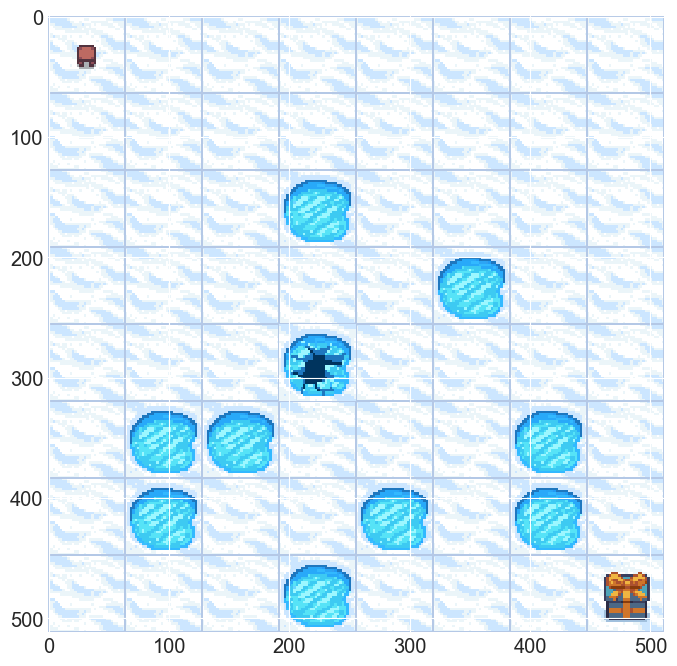

In [14]:
for i in actions:
    observation, reward, terminated, truncated, info  =env.step(i)
    img  = plt.imshow(env.render())

In [15]:
from collections import defaultdict

def fn_first_visit_prediction(env, n_episodes = EPISODES):
    value_table = defaultdict(float)
    N = defaultdict(int)
    
    for _ in trange(n_episodes):
        
        states, _, rewards = fn_generate_episodes(env)
       #print(states, rewards)
        returns = 0
        for t in range(len(states)-1, -1, -1):
            R = rewards[t]
            S = states[t]
            returns += R
            
            # checking for first visit
            if S in states[:t]:
                N[S] += 1
                value_table[S] += (returns - value_table[S])/N[S]     # rolling mean
    return value_table
#fn_first_visit_prediction(env)

In [16]:
value = fn_first_visit_prediction(env)

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:50<00:00, 1966.14it/s]


In [17]:
def fn_get_optimal_policy(grid, V):
    policy = np.zeros((grid.observation_space.n, grid.action_space.n))
    
    for state in range(grid.observation_space.n):
        action_values = np.zeros((grid.action_space.n))
        
        for action in range(grid.action_space.n):
            for probability, next_state, reward, terminated in grid.unwrapped.P[state][action]:
                action_values[action] += probability *(reward + GAMMA *V[next_state])
        best_action = np.argmax(action_values)
        policy[state][best_action] = 1.0
    return policy      

In [18]:
policy = fn_get_optimal_policy(env, value)
policy

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],


In [19]:
plot_grid = np.zeros((8,8))

for k in value.keys():
    i = k//8
    j = k%8
    plot_grid[i,j] = value[k]
plot_grid

array([[0.002, 0.002, 0.002, 0.003, 0.005, 0.008, 0.013, 0.014],
       [0.001, 0.001, 0.002, 0.002, 0.005, 0.008, 0.013, 0.014],
       [0.001, 0.001, 0.   , 0.   , 0.004, 0.008, 0.016, 0.02 ],
       [0.001, 0.001, 0.001, 0.   , 0.003, 0.   , 0.019, 0.037],
       [0.   , 0.   , 0.   , 0.   , 0.005, 0.007, 0.026, 0.085],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.012, 0.   , 0.194],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.111, 0.   , 0.416],
       [0.   , 0.   , 0.   , 0.   , 0.182, 0.3  , 0.667, 0.   ]])

<Axes: >

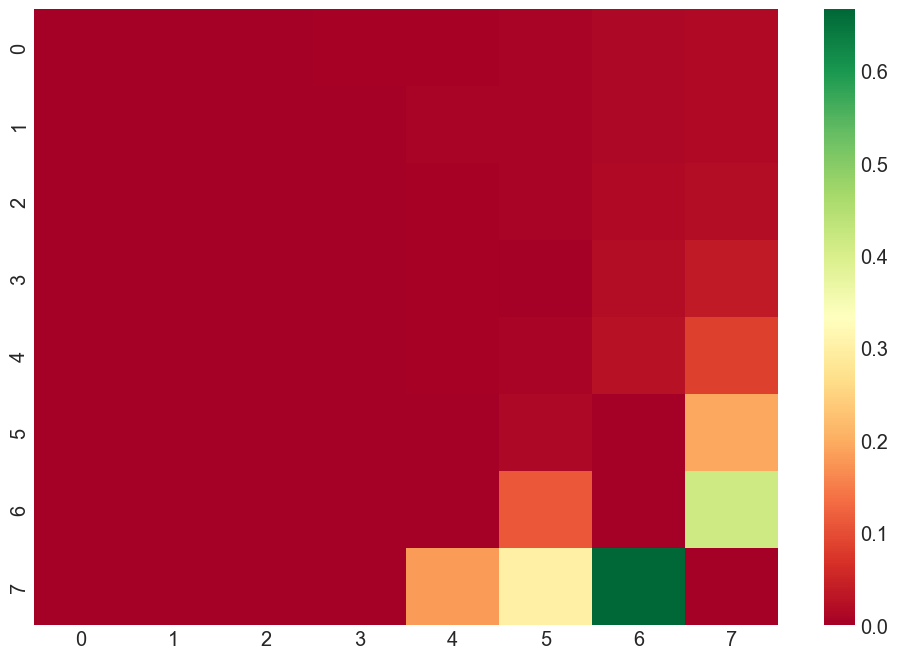

In [20]:
sns.heatmap(plot_grid, cmap = 'RdYlGn')

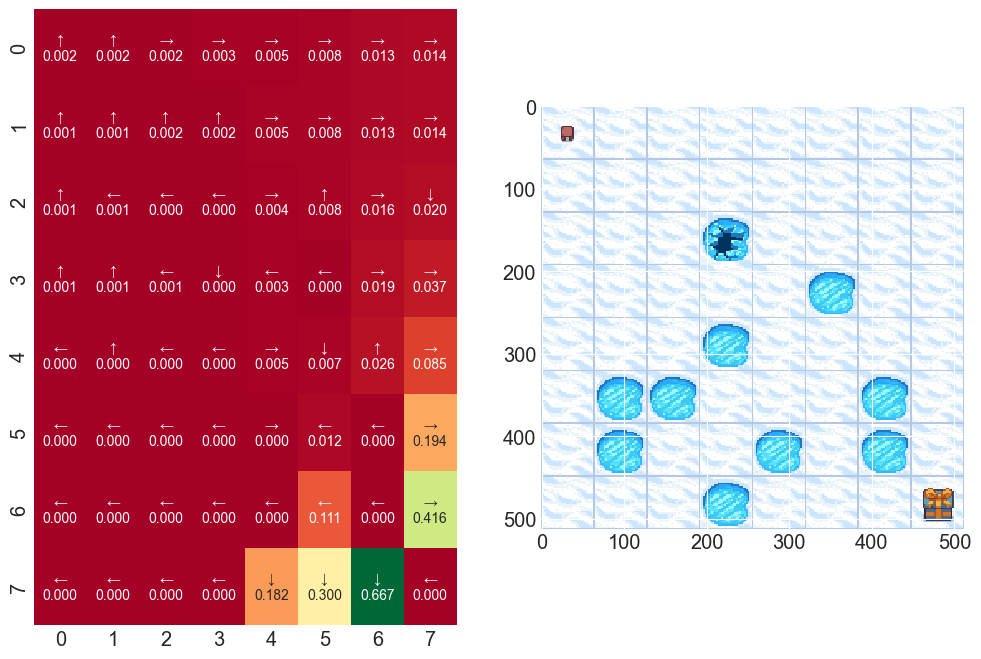

In [24]:
fig, axes = plt.subplots(1,2)

act = [action_mapping[action] for action in np.argmax(policy, axis = 1)]

labels = np.asarray([f'{a}\n{v:.3f}'
                     for a, v in zip(act, plot_grid.ravel())]).reshape(8,8)

sns.heatmap(plot_grid, annot = labels,
            fmt = '', cmap = 'RdYlGn',
            ax = axes[0], cbar = False)
axes[1].imshow(env.render());

In [25]:
labels

array([['↑\n0.002', '↑\n0.002', '→\n0.002', '→\n0.003', '→\n0.005',
        '→\n0.008', '→\n0.013', '→\n0.014'],
       ['↑\n0.001', '↑\n0.001', '↑\n0.002', '↑\n0.002', '→\n0.005',
        '→\n0.008', '→\n0.013', '→\n0.014'],
       ['↑\n0.001', '←\n0.001', '←\n0.000', '←\n0.000', '→\n0.004',
        '↑\n0.008', '→\n0.016', '↓\n0.020'],
       ['↑\n0.001', '↑\n0.001', '←\n0.001', '↓\n0.000', '←\n0.003',
        '←\n0.000', '→\n0.019', '→\n0.037'],
       ['←\n0.000', '↑\n0.000', '←\n0.000', '←\n0.000', '→\n0.005',
        '↓\n0.007', '↑\n0.026', '→\n0.085'],
       ['←\n0.000', '←\n0.000', '←\n0.000', '←\n0.000', '→\n0.000',
        '←\n0.012', '←\n0.000', '→\n0.194'],
       ['←\n0.000', '←\n0.000', '←\n0.000', '←\n0.000', '←\n0.000',
        '←\n0.111', '←\n0.000', '→\n0.416'],
       ['←\n0.000', '←\n0.000', '←\n0.000', '←\n0.000', '↓\n0.182',
        '↓\n0.300', '↓\n0.667', '←\n0.000']], dtype='<U7')

In [39]:
n_iteration = 100
data_row = []
highscore = 0

for n_iter in trange(n_iteration):
    points = 0
    data_dict = {}
    for i_episode in range(20):
        observation = env.reset()[0]
        while True:
            action = np.argmax(policy[observation])
            observation, reward, terminated, truncated, info = env.step(action)
            points += reward
            
            done = terminated or truncated
            if done:
                if points > highscore:
                    highscore = points
                break
    data_dict['run'] = n_iter
    data_dict['Points'] = points
    data_row.append(data_dict)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 63.05it/s]


In [40]:
results_df = pd.DataFrame(data_row)
results_df.head()

,run,Points
0,0,15.0
1,1,9.0
2,2,14.0
3,3,11.0
4,4,15.0


Text(0.5, 1.0, 'High: 17.0')

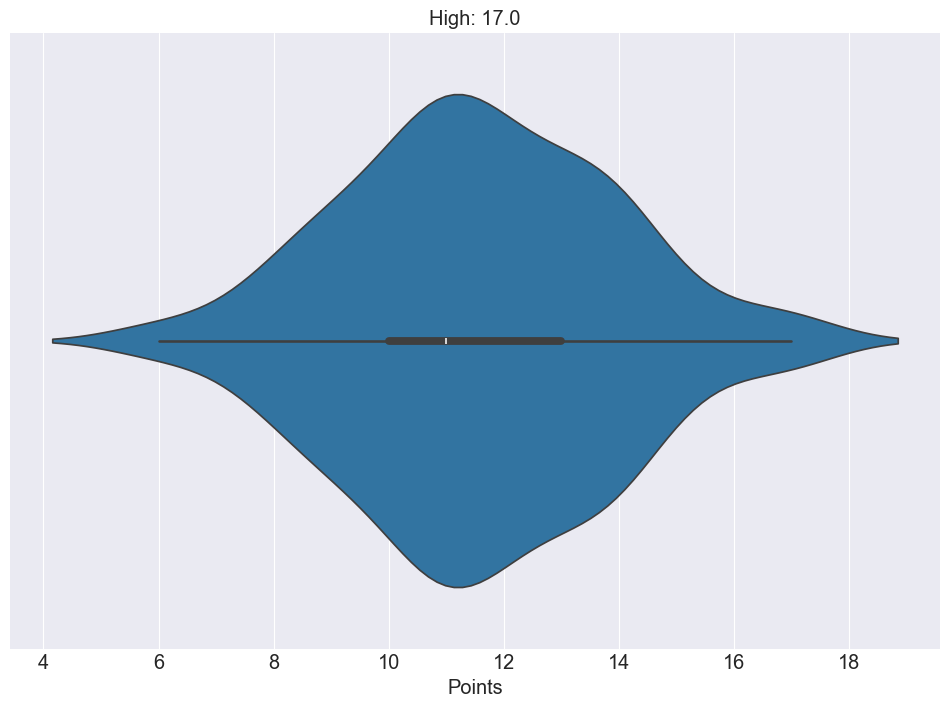

In [41]:
ax = sns.violinplot(x = results_df['Points'])

ax.set_title(f'High: {highscore}')